<a href="https://colab.research.google.com/github/anjusaji12/INTERNSHIP/blob/main/Amazon_Fine_Food_Reviews_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Review Analyis

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

**The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.**





Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10






**Attribute Information:**


Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who voted whether they found
the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

# Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).



[Q] How to determine if a review is positive or negative?


[Ans] We could use the Score/Rating. A rating of 4 or 5 could be considered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Loading the data
The dataset is available in two forms

.csv file

SQLite Database


In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.


Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
 #command in Jupyter Notebook (or JupyterLab) used to display Matplotlib plots directly inside the notebook.


%matplotlib inline

#To ignore the warning msg we import warnings

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 18.6 MB/s eta 0:00:00


In [ ]:
#import libraries

import sqlite3
import nltk                #used for NLP
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer

#Tfidf converts term counts (from a CountVectorizer) into TF-IDF weights.It does only the transformation — not tokenization or word counting.

from sklearn.feature_extraction.text import TfidfVectorizer

#converts a collection of raw text documents into a matrix of TF-IDF features in one single step.

from sklearn.feature_extraction.text import CountVectorizer

#convert text documents into a matrix of token counts — also known as a Bag of Words (BoW) representation.

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
#roc_curve
#Computes the Receiver Operating Characteristic (ROC) curve — a graphical plot showing the trade-off between:
#True Positive Rate (TPR) — also called recall or sensitivity
#False Positive Rate (FPR) — the fraction of negatives incorrectly classified as positives.

#auc
#Stands for Area Under the Curve (specifically, under the ROC curve).
#Gives a single numeric score summarizing the ROC curve.
#Value ranges between 0 and 1:


import re     #reagular expressions

# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#Used for stemming, which means reducing words to their root form. eg: running --> run

from nltk.stem.wordnet import WordNetLemmatizer

#Lemmatization is the process of reducing words to their meaningful base form (lemma) using linguistic knowledge

from gensim.models import Word2Vec

#Word2Vec is a model for learning word embeddings —
#that is, representing words as vectors of numbers that capture their semantic meaning and relationships.

from gensim.models import KeyedVectors

#KeyedVectors is used to load and work with pre-trained word embeddings
#(e.g., Google Word2Vec, GloVe, FastText) without training a new model.
#It only stores word-to-vector mappings, not the training weight

import pickle

from tqdm import tqdm

#qdm is a Python library used to display progress bars for loops or iterable operations.
#from tqdm import tqdm lets you wrap any iterable (like lists, ranges, or DataFrames) and see real-time progress in the console or notebook.

import os

#The os module is part of Python’s standard library and provides functions to interact with the operating system.



#[1]. Reading Data

In [ ]:
# using the SQLite Table to read data.

con = sqlite3.connect('/content/drive/MyDrive/APIES_AI WORKS/Amazon_food_reviw/database.sqlite')

#filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3 LIMIT 10000""",con)

#Give reviews with score>3 a positive rating and reviews with a score<3 a negative rating

def partition(x):
  if x>3:
    return 0  #positive
  return 1  #negative




In [ ]:
filtered_data

Id   ProductId          UserId                      ProfileName  \
0         1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1         2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2         3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3         4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4         5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...     ...         ...             ...                              ...   
9995  10921  B000EM6PC6  A1JTDH5IPXPXIQ                 Deborah Phillips   
9996  10922  B000EM6PC6  A27NS4P689K2C5                 Richard F. Smith   
9997  10923  B000EM6PC6  A3JLS33T28VGYZ     Bobbie J. Atkins "BOBBIEJ'S"   
9998  10925  B000EM6PC6  A1GW6Y0UTG7ZN2                    Kelly "Kelly"   
9999  10926  B000EM6PC6   AUWXYJE48MGEV                         Kennarog   

      HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                        1                       1      5  1303862400   
1                        0                       0      1  1346976000   
2                        1                       1      4  1219017600   
3                        3                       3      2  1307923200   
4                        0                       0      5  1350777600   
...                    ...                     ...    ...         ...   
9995                     1                       1      5  1182470400   
9996                     1                       1      5  1181692800   
9997                     1                       1      5  1181174400   
9998                     2                       3      4  1268784000   
9999                     0                       0      5  1349395200   

                                         Summary  \
0                          Good Quality Dog Food   
1                              Not as Advertised   
2                          "Delight" says it all   
3                                 Cough Medicine   
4                                    Great taffy   
...                                          ...   
9995              the greatest tea in my opinion   
9996                                         Tea   
9997                                   GREAT TEA   
9998  Help, My stomach gets upset with this tea.   
9999                          Lipton's Loose Tea   

                                                   Text  
0     I have bought several of the Vitality canned d...  
1     Product arrived labeled as Jumbo Salted Peanut...  
2     This is a confection that has been around a fe...  
3     If you are looking for the secret ingredient i...  
4     Great taffy at a great price.  There was a wid...  
...                                                 ...  
9995  I was so disappointed to find that the two sto...  
9996  It's very hard to find this product in local g...  
9997  GREAT TEA.  IF ANYONE HAS NOT TRIED LOOSE TEA ...  
9998  I have always loved Lipton teas. It is a daily...  
9999  I love this tea!!  I drink it every day of the...  

[10000 rows x 10 columns]

In [ ]:
#changing reviews with score less than 3 to be positive and vice-versa

actualscore = filtered_data['Score']
positivenegative = actualscore.map(partition)
filtered_data['Score'] = positivenegative
print(" Number of Data Points in our Data",filtered_data.shape)

 Number of Data Points in our Data (10000, 10)


In [ ]:
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      0  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      0  1219017600   
3                     3                       3      1  1307923200   
4                     0                       0      0  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

In [ ]:
#sql query for finding the usedid with more than one review

display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
display

UserId   ProductId               ProfileName        Time  \
0      #oc-R115TNMSPFT9I7  B005ZBZLT4                   Breyton  1331510400   
1      #oc-R11D9D7SHXIJB9  B005HG9ESG    Louis E. Emory "hoppy"  1342396800   
2      #oc-R11DNU2NBKQ23Z  B005ZBZLT4          Kim Cieszykowski  1348531200   
3      #oc-R11O5J5ZVQE25C  B005HG9ESG             Penguin Chick  1346889600   
4      #oc-R12KPBODL2B5ZD  B007OSBEV0     Christopher P. Presta  1348617600   
...                   ...         ...                       ...         ...   
80663       AZZNK89PXD006  B001J3ZUQ6                     Etude  1269648000   
80664       AZZTH6DJ0KSIP  B00014IVPQ           Crystal Caccamo  1304208000   
80665       AZZU1VEO8KUXH  B003FDC2I2             Mia P "Mia P"  1317513600   
80666       AZZU4D6TZ2L6J  B0029XITW2  Sherry King "llamasmama"  1247875200   
80667       AZZV9PDNMCOZW  B001E5E2QI  Anne B. Ward "Dr Anne B"  1310428800   

       Score                                               Text  COUNT(*)  
0          2  Overall its just OK when considering the price...         2  
1          5  My wife has recurring extreme muscle spasms, u...         3  
2          1  This coffee is horrible and unfortunately not ...         2  
3          5  This will be the bottle that you grab from the...         3  
4          1  I didnt like this coffee. Instead of telling y...         2  
...      ...                                                ...       ...  
80663      5  In this package you get three varieties of pop...         6  
80664      5  ive bought a few different kinds and i feel th...         3  
80665      5  I bought this for my 13 year old daughter who ...         3  
80666      5  My father thought this was the best cheese eve...         2  
80667      5  I love this syrup. It is my personal substitut...         3  

[80668 rows x 7 columns]

In [ ]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B005ZBZLT4                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ESG  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B005ZBZLT4        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ESG           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBEV0   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B001ATMQK2  undertheshrine "undertheshrine"  1296691200   

       Score                                               Text  COUNT(*)  
80638      5  I bought this 6 pack because for the price tha...         5

In [ ]:
display['COUNT(*)'].sum()  #sum of the colummn name count in display

np.int64(393063)

#Exploratory Data Analysis
#[2] Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

In [ ]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score !=3 AND UserId ="AR5J8UI46CURR"
ORDER BY ProductID""",con)

In [ ]:

display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that



ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)


ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on


It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.


The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order

sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [ ]:

sorted_data.head()

Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
2547  2775  B00002NCJC  A13RRPGE79XFFH      reader48                     0   
2546  2774  B00002NCJC  A196AJHU9EASJN  Alex Chaffee                     0   
1145  1244  B00002Z754  A3B8RCEI0FXFI6     B G Chase                    10   
1146  1245  B00002Z754  A29Z5PI9BW2PU3        Robbie                     7   
8695  9526  B00005V3DC    APASCXWTM041      Ed Raton                     0   

      HelpfulnessDenominator  Score        Time  \
2547                       0      0  1281052800   
2546                       0      0  1282953600   
1145                      10      0   962236800   
1146                       7      0   961718400   
8695                       0      0  1350604800   

                             Summary  \
2547                    Flies Begone   
2546                   thirty bucks?   
1145  WOW Make your own 'slickers' !   
1146                   Great Product   
8695         Good, effective product   

                                                   Text  
2547  We have used the Victor fly bait for 3 seasons...  
2546  Why is this $[...] when the same product is av...  
1145  I just received my shipment and could hardly w...  
1146  This was a really good idea and the final prod...  
8695  Good flavor, unique in all the teas that I've ...

In [ ]:
#Deduplication of entries

final_sort = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

In [ ]:
print(final_sort.shape)

(9564, 10)


In [ ]:
#Checking to see how much % of data still remains
(final_sort['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

In [ ]:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE HelpfulnessNumerator > HelpfulnessDenominator""",con)

In [ ]:
display.head()

Id   ProductId          UserId              ProfileName  \
0  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   
1  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       2      4  1212883200   
1                     3                       1      5  1224892800   

                                        Summary  \
0  Pure cocoa taste with crunchy almonds inside   
1             Bought This for My Son at College   

                                                Text  
0  It was almost a 'love at first bite' - the per...  
1  My son loves spaghetti so I didn't hesitate or...

**Observation**:- It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [ ]:
#The GROUP BY clause in SQL is used to arrange identical data into groups, often for aggregation (like COUNT(), SUM(), AVG(), etc.)
#The ORDER BY clause in SQL is used to sort the result set of a query — either in ascending or descending order.

In [ ]:
final_sort = final_sort[final_sort.HelpfulnessNumerator <= final_sort.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final_sort.shape)

#How many positive and negative reviews are present in our dataset?
final_sort['Score'].value_counts()

(9564, 10)


Score
0    7976
1    1588
Name: count, dtype: int64

#[3]. Text Preprocessing.
Now that we have finished duplication our data requires some preprocessing before we go on further with analysis and making the prediction model.


**Hence in the Preprocessing phase we do the following in the order below**:-


Begin by removing the html tags

Remove any punctuations or limited set of special characters like , or . or # etc.

Check if the word is made up of english letters and is not alpha-numeric

Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

Convert the word to lowercase

Remove Stopwords

Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
rand_0 = final_sort['Text'].values[0]
print(rand_0)
print('-'*80)

rand_1000 = final_sort['Text'].values[1000]
print(rand_1000)
print('-'*80)

rand_1500 = final_sort['Text'].values[1500]
print(rand_1500)
print("-"*50)

rand_4900 = final_sort['Text'].values[4900]
print(rand_4900)
print("-"*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
--------------------------------------------------------------------------------
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
--------------------------------------------------------------------------------
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
--------------------------------------------------
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit 

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039

rand_0 = re.sub(r"http\S+","",rand_0)  # http\S+- starts with http and have one or more characters otherthan space
rand_1000 = re.sub(r"http\S+","",rand_1000)
rand_1500 = re.sub(r"http\S+","",rand_1500)
rand_4900 = re.sub(r"http\S+","",rand_4900)
print(rand_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


REGULAR EXPRESSION

In [ ]:
# \d -->	Any digit (0–9)
# \D --> Any non-digit
# \w -->	Alpha numerics
# \W -->  Non alpha numerics
# \s --> 	Whitespace
# \S -->	non white space
# ^  -->  start of string, or line
#$   -->	end of string, or line
# \A  -->	start of string
# \Z	--> end of string
# \b  -->	empty string at the beginning or end of a word
# \B	--> empty string not at the beginning or end of a word
# [arn] -->	Returns a match where one of the specified characters (a, r, or n) is present
# [a-n]	--> Returns a match for any lower case character, alphabetically between a and n
# [^arn] -->	Returns a match for any character EXCEPT a, r, and n
# [0123] -->	Returns a match where any of the specified digits (0, 1, 2, or 3) are present
# [0-9] -->	Returns a match for any digit between 0 and 9
# [0-5][0-9]	--> Returns a match for any two-digit numbers from 00 and 59
# [a-zA-Z] -->	Returns a match for any character alphabetically between a and z, lower case OR upper case
# [+]	--> In sets, +, *, ., |, (), $,{} has no special meaning, so [+] means: return a match for any + character in the string

In [ ]:
#Remove all the tags from an element so we use BeautifulSoup
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

In [ ]:
from bs4 import BeautifulSoup

# Imports BeautifulSoup, a library used for analysing HTML or XML documents.
# It helps extract clean text from data that contains HTML tags, like <br>, <p>, <a>, etc

soup = BeautifulSoup(rand_0,'html.parser')
text = soup.get_text()
print(text)
print('-'*30)

soup = BeautifulSoup(rand_1000, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(rand_1500, 'html.parser')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(rand_4900, 'html.parser')
text = soup.get_text()
print(text)



We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
------------------------------
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines

In [ ]:
#Expanding English Language contractions in python
#you've ---> you have
#he's ---> he is

# https://stackoverflow.com/a/47091490/4084039


In [ ]:
import re
def decontracted(phrase):
  #specific
    phase = re.sub(r"wont't","will not",phrase)
    pharse = re.sub(r"can't","can not",phrase)

  #general
    phrase = re.sub(r"n\'t","not",phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s",'is',phrase)
    phrase = re.sub(r"\'d","would",phrase)
    phrase = re.sub(r"\'ll","will",phrase)
    phrase = re.sub(r"\'t","not",phrase)
    phrase = re.sub(r"\'ve","have",phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [ ]:
rand_1500 = decontracted(rand_1500)
print(rand_1500)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldnot belive my taste buds. Thatis why I excited why I saw them here on Amazon, and decided to buy a case!


In [ ]:
#Python regax to remove all word which contain  numbers
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039

In [ ]:
# re.sub(pattern, replacement, text)

In [ ]:
#remove words with numbers
rand_0 = re.sub("\S*\d\S*","",rand_0).strip()  #continuous non-space sequence that contains at least one digit
# strip() Removes any leading or trailing spaces left after removing those words.
print(rand_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [ ]:
#remove all special character ,punctuations and spaces fromo string
#remove spacial character: https://stackoverflow.com/a/5843547/4084039

rand_1500 = re.sub("[^A-Za-z0-9]+"," ",rand_0)  #any sequence of one or more characters that are NOT letters or digits
print(rand_1500)

We have used the Victor fly bait for seasons Can t beat it Great product 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have removed in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

remove http -removexml/html -remove alpha numeric or numeric -remove special char -removestopword -decontraction

In [ ]:
# Combining all the above stundents

from tqdm import tqdm
preprocessed_review = []
# tqdm is for printing the status bar

for sentance in tqdm(final_sort['Text'].values):
    sentance = re.sub(r"http\S+","",sentance)
    sentance = BeautifulSoup (sentance,'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*","",sentance).strip()
    sentance = re.sub("[^A-Za-z]+"," ",sentance)

    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_review.append(sentance.strip())

100%|██████████| 9564/9564 [00:06<00:00, 1445.96it/s]


In [ ]:
preprocessed_review[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store couldnot belive taste buds thatis excited saw amazon decided buy case'

In [ ]:
preprocessed_review

['used victor fly bait seasons canot beat great product',
 'product available victor traps unreal course total fly genocide pretty stinky right nearby',
 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'good flavor unique teas ihave tried tea effective cleansing oneis system not harsh regular laxative consumed daily needed',
 'ihave used brand years feeling clogged ate massive meal sips tea new make sure home work little well know mean careful first couple times using try little sips youwill see result morning earlier follow lots water',
 'new product need careful dosage strong batches stronger others',
 'using food months find excellent fact t

#Encoding

**Why are word embeddings needed?**

Let us consider the two sentences – “You can scale your business.” and “You can grow your business.”. These two sentences have the same meaning. If we consider a vocabulary considering these two sentences, it will constitute of these words: {You, can, scale, grow, your, business}.


A one-hot encoding of these words would create a vector of length 6. The encodings for each of the words would look like this:


You: [1,0,0,0,0,0], Can: [0,1,0,0,0,0], Scale: [0,0,1,0,0,0], Grow: [0,0,0,1,0,0],


Your: [0,0,0,0,1,0], Business: [0,0,0,0,0,1]


In a 6-dimensional space, each word would occupy one of the dimensions, meaning that none of these words has any similarity with each other – irrespective of their literal meanings.


Word2Vec, a word embedding methodology, solves this issue and enables similar words to have similar dimensions and, consequently, helps bring context.


https://www.analyticsvidhya.com/blog/2021/07/word2vec-for-word-embeddings-a-beginners-guide/

#Featurization

suppose we have a columnm color:

colour

red

green

blue

red



# one Hot Encoding

BAG OF WORDS

In [ ]:
#for example
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(["i love machine learning machine", "i love deep learning"])
print(count_vect.get_feature_names_out())


['deep' 'learning' 'love' 'machine']


In [ ]:
#eg:
final = count_vect.transform(["i love machine learning machine", "i love deep learning"])
final

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 6 stored elements and shape (2, 4)>

In [ ]:
#eg
print(final.toarray())

[[0 1 1 2]
 [1 1 1 0]]


In [ ]:
#BOW
count_vect = CountVectorizer()
count_vect.fit(preprocessed_review)
print("Some feature name:",count_vect.get_feature_names_out()[:10])


Some feature name: ['aa' 'aaaa' 'aahhhs' 'ab' 'aback' 'abandon' 'abates' 'abberline' 'abbott'
 'abby']


In [ ]:
final_counts = count_vect.transform(preprocessed_review)
print('the type of count vectorizer',type(final_counts))
print('the shape of out text BOW vectorizer',final_counts.get_shape())
print('the number of unique words',final_counts.get_shape()[1])

the type of count vectorizer <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer (9564, 18693)
the number of unique words 18693


#Bi Grams and n Grams

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice

count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)
final_bigram_count = count_vect.fit_transform(preprocessed_review)
print('the type of count vectorizer',type(final_bigram_count))
print("the shape of out text BOW vectorizer ",final_bigram_count.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_count.get_shape()[1])


the type of count vectorizer <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (9564, 5000)
the number of unique words including both unigrams and bigrams  5000


# TF-IDF

In [ ]:
# TF-IDF stands for:
# Term Frequency – Inverse Document Frequency
# It’s a numerical representation of text that highlights important words in a document while reducing the weight of common words.


# Term Frequency (TF)
# Measures how often a word appears in a document.
# Formula:
#TF(word)=(Total number of words in docNumber of times) /(word appears in doc)

# Inverse Document Frequency (IDF)
# Measures how rare or common a word is across all documents.
# Words that appear in many documents (like “the”, “is”) get lower weight.
# Formula:
#IDF(word)=log[(Total number of documents)​/(1+Number of documents containing the word)]

# 	Combines TF and IDF:
# 𝑇𝐹-𝐼𝐷𝐹(𝑤𝑜𝑟𝑑)=𝑇𝐹(𝑤𝑜𝑟𝑑)×𝐼𝐷𝐹(𝑤𝑜𝑟𝑑)

#  This gives high weight to words that are frequent in a document but rare across all documents.

# Why TF-IDF is useful

# Converts text into numbers for ML models
# Highlights important words in documents

# Used in:
# Text classification (spam detection, sentiment analysis)
# Search engines / information retrieval
# Recommender systems


In [ ]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_vect.fit(preprocessed_review)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('-'*30)

final_tf_idf = tf_idf_vect.transform(preprocessed_review)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability' 'able' 'able buy' 'able eat' 'able find' 'able get'
 'able order' 'able use' 'absolute' 'absolute best']
------------------------------
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9564, 5804)
the number of unique words including both unigrams and bigrams  5804


# Word2vec

Word2Vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors.

In [ ]:
!pip install gensim

In [ ]:
#eg for word2vec
from gensim.models import Word2Vec
#sample corpus (list of sentences, each sentence is a list of words)
sentences=[
    ["I", "love", "machine", "learning"],
    ["Deep", "learning", "is", "fun"],
    ["I", "enjoy", "learning", "new", "things"]
]

# Train Word2Vec model
# vector_size = dimensions of the word vectors
# window = context window size
# min_count = ignore words appearing less than this

model = Word2Vec(sentences, vector_size=10, window=3, min_count=1, sg=0)

# sg=0 =>CBOW (Continuous Bag of Words)Predicts a target word from its surrounding context words.
# Get vector for a word
vector = model.wv['learning']
print("Vector for 'learning':")
print(vector)

# Find similar words
similar = model.wv.most_similar('learning', topn=3)
print("\nTop 3 words similar to 'learning':")
print(similar)

Vector for 'learning':
[-0.00536227  0.00236431  0.0510335   0.09009273 -0.0930295  -0.07116809
  0.06458873  0.08972988 -0.05015428 -0.03763372]

Top 3 words similar to 'learning':
[('I', 0.5436005592346191), ('machine', 0.3792896568775177), ('things', 0.3004249036312103)]


In [ ]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_review:
    list_of_sentance.append(sentance.split())


In [ ]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False  #Whether your system has enough memory (≥16 GB)
want_to_use_google_w2v = False  #Use pre-trained Google Word2Vec (if True)
want_to_train_w2v = True  #Train your own Word2Vec model (if True)

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    #min_count=5: Ignore words that appear fewer than 5 times.
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=100, workers=4)
    #Finds words with similar meaning to “great”, based on learned vectors.
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.895307183265686), ('excellent', 0.8877646327018738), ('overall', 0.7844387292861938), ('decent', 0.7688888907432556), ('wonderful', 0.7653387784957886), ('especially', 0.7643014192581177), ('tasty', 0.7558264136314392), ('super', 0.7516137957572937), ('value', 0.7433299422264099), ('amazing', 0.7424827218055725)]
[('eaten', 0.9821870923042297), ('absolute', 0.9794696569442749), ('types', 0.9744853377342224), ('varieties', 0.9741576313972473), ('various', 0.9730281233787537), ('compleats', 0.9681515097618103), ('youhave', 0.9669955372810364), ('hands', 0.9669321775436401), ('kinds', 0.9661802053451538), ('britt', 0.9652563333511353)]


In [ ]:
w2v_words = list(w2v_model.wv.index_to_key)
# .index_to_key → returns a list of all words in the model, sorted by frequency (most frequent first).
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5725
sample words  ['not', 'like', 'good', 'great', 'taste', 'coffee', 'one', 'product', 'flavor', 'itis', 'love', 'would', 'no', 'tea', 'food', 'really', 'get', 'much', 'use', 'best', 'time', 'donot', 'also', 'tried', 'amazon', 'little', 'make', 'buy', 'price', 'find', 'well', 'better', 'try', 'even', 'cup', 'ihave', 'chips', 'bag', 'chocolate', 'sugar', 'water', 'eat', 'first', 'hot', 'drink', 'made', 'found', 'mix', 'used', 'bought']


#[4.4.1] Converting text into vectors using wAvg W2V, TFIDF-W2V

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []   # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance):  # for each review/sentence
    sent_vec = np.zeros(100)   # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_word =0     # num of words with a valid vector in the sentence/review
    for word in sent:    # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec +=vec
            cnt_word +=1
    if cnt_word!=0:
      sent_vec/= cnt_word
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))



100%|██████████| 9564/9564 [00:15<00:00, 603.81it/s]

9564
100


# [4.4.1.2] TFIDF weighted W2v

In [ ]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(preprocessed_review)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))


#model.get_feature_names_out() → list of all words (vocabulary)
# model.idf_ → list of IDF scores for each word
# zip() → pairs them together
# dict() → converts it into a dictionary for easy lookup
# TfidfVectorizer() ->	Initializes TF-IDF transformer
# .fit(preprocessed_review) ->	Learns words & their IDF scores
# .get_feature_names_out() ->	Returns all unique words
# .idf_	 ->Gives IDF values for those words
# dict(zip(...))	Creates word → IDF mapping

tfidf_sent_vectors - train test split - ml algoriths | accuracy,p,r,confusion max

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out()
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = []  # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in tqdm(list_of_sentance):  # for each review/sentence #tqdm is a Python library used to show a progress bar for loops
    sent_vec = np.zeros(100)   # as word vectors are of zero length
    weight_sum =0;    # num of words with a valid vector in the sentence/review
    for word in sent:   # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#        # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review

            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 9564/9564 [02:46<00:00, 57.55it/s]


In [ ]:
type(final)

scipy.sparse._csr.csr_matrix

Machine Learning Model

In [ ]:
#importing libraries
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,ConfusionMatrixDisplay,confusion_matrix


In [ ]:
x=tfidf_sent_vectors
x

[array([ 0.08991604,  0.14622465,  0.07868414, -0.00146897,  0.11774433,
        -0.35027725,  0.05118122,  0.3457705 , -0.20513715, -0.19494592,
         0.00584628, -0.3301602 ,  0.11012933,  0.18788178,  0.16963857,
        -0.07896437,  0.1025125 , -0.38426846, -0.0205272 , -0.41582316,
         0.01753948,  0.13323953, -0.03921058, -0.04670079, -0.18197177,
         0.0744269 , -0.1144559 , -0.01580325, -0.11306472,  0.02779894,
         0.29145256,  0.12929504,  0.10701506, -0.1816658 , -0.14543887,
         0.2441427 ,  0.11741942, -0.09200161, -0.10482656, -0.30298573,
        -0.09381845, -0.21688895,  0.03500262, -0.07873176,  0.20737074,
         0.16878229, -0.20773583, -0.01893468, -0.00596975,  0.0650099 ,
         0.13881857, -0.07606754, -0.21990118, -0.164006  , -0.01923329,
         0.18845201,  0.13994087,  0.01615089, -0.02670351,  0.28824692,
         0.02865553,  0.04742041, -0.01111647,  0.03566737, -0.17042279,
         0.02603215,  0.13904425,  0.01582117, -0.2

In [ ]:
y=final_sort['Score']
y

2547    0
2546    0
1145    0
1146    0
8695    0
       ..
710     0
709     0
713     0
1362    1
5259    0
Name: Score, Length: 9564, dtype: int64

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
#SVM
ml = svm.SVC()
ml.fit(x_train,y_train)


SVC()

In [ ]:
y_pred = ml.predict(x_test)

In [ ]:
print("accuracy score:",accuracy_score(y_test,y_pred))
print('precision:',precision_score(y_test,y_pred))
print('recall score:',recall_score(y_test,y_pred))
print('confusion matrix\n:',confusion_matrix(y_test,y_pred))

accuracy score: 0.8233141662310507
precision: 0.0
recall score: 0.0
confusion matrix
: [[1575    0]
 [ 338    0]]


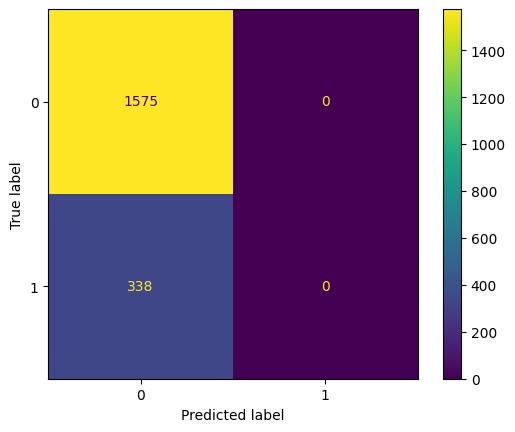

In [ ]:
ConfusionMatrixDisplay.from_estimator(ml, x_test, y_test)

In [ ]:
#Decison Tree
clf = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
pred=clf.predict(x_test)

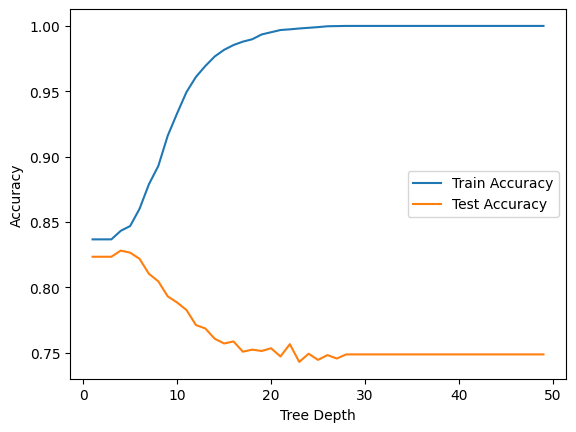

In [ ]:
from sklearn.tree import DecisionTreeClassifier

train_acc, test_acc = [], []
for d in range(1, 50):
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(x_train, y_train)
    train_acc.append(clf.score(x_train, y_train))
    test_acc.append(clf.score(x_test, y_test))

plt.plot(range(1,50), train_acc, label='Train Accuracy')
plt.plot(range(1,50), test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth'); plt.ylabel('Accuracy'); plt.legend()
plt.show()

Accuracy: 0.8233141662310507


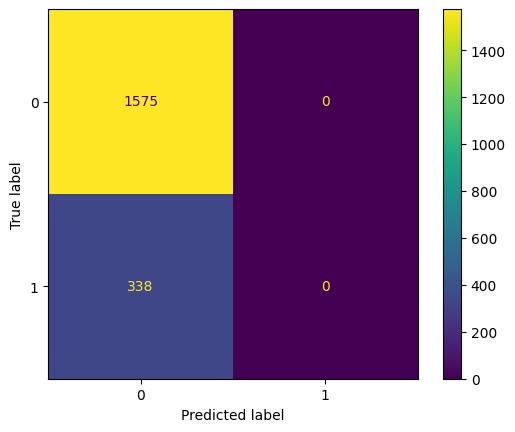

In [ ]:
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

### Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy:", accuracy_score(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test)
plt.show()

In [ ]:
#Logistic Regression
lr = LogisticRegression(fit_intercept =True,penalty='l1',solver='liblinear')
lr.fit(x_train,y_train)


LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
lr_pred = lr.predict(x_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(lr_pred, name = 'Predict'), margins = True)

Predict    0   1  All
Actual               
0        328  20  348
1         58   8   66
All      386  28  414

In [ ]:
print("accuracy score:",accuracy_score(y_test,y_pred))
print('precision:',precision_score(y_test,y_pred))
print('recall score:',recall_score(y_test,y_pred))
print('confusion matrix\n:',confusion_matrix(y_test,y_pred))


accuracy score: 0.8233141662310507
precision: 0.0
recall score: 0.0
confusion matrix
: [[1575    0]
 [ 338    0]]


Observation

SVM Model with accuracy :82

Decision tree with accuracy :82

Logistic Regression with accuracy :81

# Working on summary column

In [ ]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents


from tqdm import tqdm
from bs4 import BeautifulSoup
import re


preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final_sort['Summary']): # Iterate directly over the Series
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 9564/9564 [00:00<00:00, 16174.82it/s]


In [92]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_1=[]
for sentance in preprocessed_summary:
    list_of_sentance_1.append(sentance.split())

In [93]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_1=Word2Vec(list_of_sentance_1,min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model_1=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))

[('like', 0.9992216229438782), ('good', 0.9991097450256348), ('best', 0.9990530610084534), ('better', 0.9990397691726685), ('not', 0.9989936351776123), ('flavor', 0.9989900588989258), ('low', 0.998968243598938), ('tea', 0.9989633560180664), ('no', 0.9989495277404785), ('perfect', 0.9989164471626282)]
[('sweet', 0.9937739968299866), ('treat', 0.9937625527381897), ('best', 0.9936158657073975), ('chips', 0.9935211539268494), ('mix', 0.9934882521629333), ('better', 0.9934704899787903), ('great', 0.9934138655662537), ('not', 0.9933891892433167), ('keurig', 0.9933564066886902), ('no', 0.9933483004570007)]


In [94]:
w2v_words_1= list(w2v_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  892
sample words  ['great', 'good', 'best', 'not', 'love', 'coffee', 'product', 'delicious', 'taste', 'tea', 'excellent', 'flavor', 'food', 'yummy', 'tasty', 'ever', 'like', 'hot', 'dog', 'price', 'chips', 'favorite', 'snack', 'chocolate', 'stuff', 'free', 'awesome', 'healthy', 'no', 'better', 'perfect', 'loves', 'k', 'cup', 'yum', 'sweet', 'wonderful', 'really', 'mix', 'quality', 'nice', 'cocoa', 'tasting', 'one', 'gluten', 'tastes', 'easy', 'buy', 'cat', 'bad']


In [100]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors1= []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_1): # for each review/sentence
    sent_vec_1= np.zeros(100) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words_1=0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_1:
            vec_1= w2v_model_1.wv[word]
            sent_vec_1 += vec
            cnt_words_1 += 1
    if cnt_words_1!= 0:
        sent_vec_1 /= cnt_words_1
    sent_vectors1.append(sent_vec_1)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

100%|██████████| 9564/9564 [00:00<00:00, 46650.42it/s]

9564
100


In [111]:
Y1 = final_sort['Score']
Y1

2547    0
2546    0
1145    0
1146    0
8695    0
       ..
710     0
709     0
713     0
1362    1
5259    0
Name: Score, Length: 9564, dtype: int64

In [112]:
X1 = sent_vectors1
X1

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.00805429,  0.12989779,  0.12495144,  0.05197928,  0.12967792,
        -0.24331293,  0.028

In [113]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X1,Y1,test_size=0.2,random_state=42)

In [116]:
# ML Models
from sklearn import svm
ml = svm.SVC()
ml.fit(X_train,Y_train)





SVC()

In [117]:
y_pred1 = ml.predict(X_test)
y_pred1

array([0, 0, 0, ..., 0, 0, 0])

accuracy_score : 0.8233141662310507


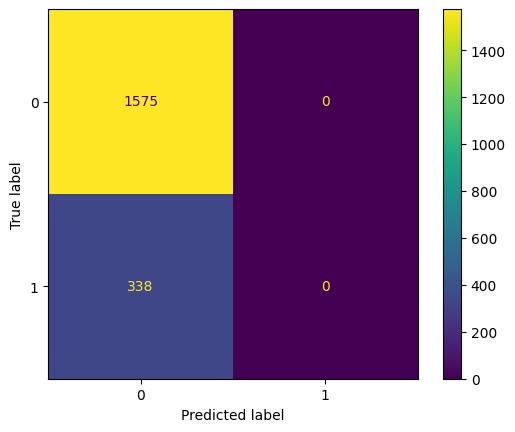

In [119]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
print('accuracy_score :',accuracy_score(Y_test,y_pred1))
ConfusionMatrixDisplay.from_estimator(ml, X_test, Y_test)

In [120]:
#Decision tree
from sklearn import tree

In [121]:
dt = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [122]:
y_pred2=dt.predict(X_test)

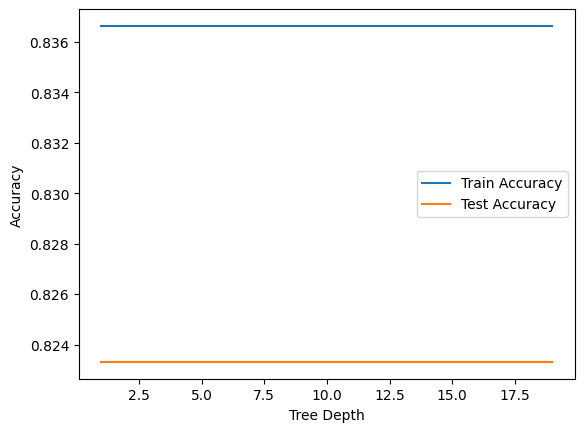

In [132]:
from sklearn.tree import DecisionTreeClassifier

train_acc1, test_acc1 = [], []
for d in range(1, 20):
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    dt.fit(X_train, Y_train)
    train_acc1.append(dt.score(X_train, Y_train))
    test_acc1.append(dt.score(X_test, Y_test))

plt.plot(range(1,20), train_acc1, label='Train Accuracy')
plt.plot(range(1,20), test_acc1 ,label='Test Accuracy')
plt.xlabel('Tree Depth'); plt.ylabel('Accuracy'); plt.legend()
plt.show()

Accuracy: 0.8233141662310507


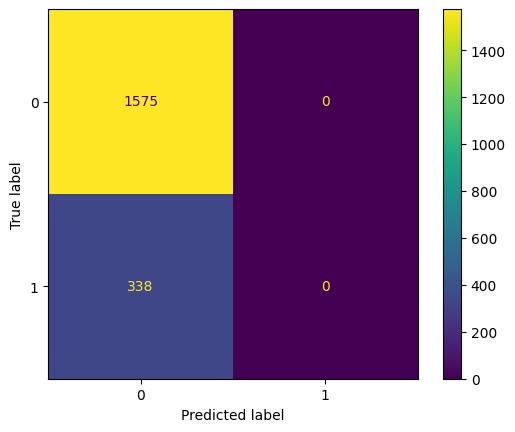

In [134]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, Y_train)
y_pred2 = dt.predict(X_test)

### Model Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy:", accuracy_score(Y_test, y_pred2))
ConfusionMatrixDisplay.from_estimator(dt, X_test, Y_test)
plt.show()


In [135]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lrm = LogisticRegression(fit_intercept =True,penalty='l1',solver='liblinear')
lrm.fit(X_train,Y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [136]:
y_pred3=lrm.predict(X_test)

accuracy score: 0.8233141662310507


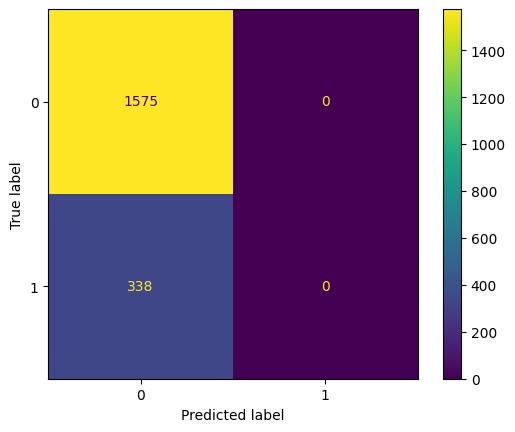

In [139]:
print("accuracy score:",accuracy_score(Y_test,y_pred3))

ConfusionMatrixDisplay.from_estimator(lrm, X_test, Y_test)
plt.show()